In [23]:
from mt.laser import get_func_gen_settings
%load_ext autoreload
%autoreload 2

import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from mt.scan import Scan
from mt.constants import ANALYSIS_SPECIMEN, SCALE_FACTOR_2D, SCALE_FACTOR_3D
from mt.ct_utils import reslice
from mt.visualization import visualize_region_properties, visualize_region_correlation
import matplotlib.pyplot as plt

with open("analytics.pkl", "rb") as file:
    analytics = pickle.load(file)
specimen_overview = pd.read_csv("specimen.csv", header=0, delimiter=";")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# analytics = {}
# for ii, specimen in enumerate(ANALYSIS_SPECIMEN):
#     print(f"Processing specimen {specimen} ({ii+1}/{len(ANALYSIS_SPECIMEN)})")
#     path = "../../04_uCT/" + specimen + "/"
#     scan = Scan(path,
#                 downscale=True)
#     scan.load(logging=True)
#     scan.calculate_properties()
#     scan.save(logging=True)
#     analytics[specimen] = scan.analytics
# with open("analytics.pkl", "wb") as file:
#     pickle.dump(analytics, file)

# Load data

In [2]:
with open("analytics.pkl", "rb") as file:
    analytics = pickle.load(file)

In [3]:
specimen_overview = pd.read_csv("specimen.csv", header=0, delimiter=";")
specimen_overview

,specimen,description,settings,Batch,results,analysis
0,BA38,Test with brass plate,standard,B6,"Brass plate absorbs heat, with standard settin...",y
1,BA37,2x normal settings,standard,B2,"with two passes of normal settings, previously...",y
2,BA36,2x normal settings,standard,B6,"to a lower degree, this also happens with the ...",y
3,AD77,cross pattern,"10 mm distance, 80 % duty cycle, 15 mm/s",B6,more evaporation in vertical cross line than h...,y
4,AD76,cross pattern,"10 mm distance, 80 % duty cycle, 30 mm/s",B6,same amount of evaporation for vertical and ho...,y
5,AD68,cross pattern,"10 mm distance, 33 % duty cycle, 10 mm/s",B6,"massive (250 um) cavity, not homogenous, some ...",y
6,AD67,standard setting batch test,standard,B2,"homogenous fusion where particles are, nearly ...",y
7,AD66,standard setting batch test,standard,B9,"homogenous fusion, some bright particle (steel...",y
8,AD64,standard setting batch test,standard,B25,"homogenous fusion, some smaller cavities, brig...",y
9,AD63,standard setting batch test,standard,B6,"homogenous fusion, some smaller cavities (more...",y


# Visualize region properties
Only for selected specimen, as the scan has to be loaded to show the X-Y slice.

In [20]:
for specimen in ANALYSIS_SPECIMEN:
    path = "../../04_uCT/" + specimen + "/"
    scan = Scan(path,
                downscale=True)
    scan.load(logging=False)

    areas = analytics[specimen]["2d_cell_area"] * SCALE_FACTOR_2D
    contact = analytics[specimen]["2d_contact_pct"]
    stack = reslice(scan.get_mask(), "z")
    image = stack[len(stack) // 2]
    fig = visualize_region_properties(image, areas, contact, fig_width=30, font_scale=2)
    fig.savefig("../../06_Results/RegionVisualizations/" + specimen + ".pdf", bbox_inches="tight", pad_inches=0)
    fig.savefig("../../06_Results/RegionVisualizations/" + specimen + ".png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)

Loading pickled Scan object from: ../../06_Results/uCT/BA38/Scan.pkl
Downscaled stack to: (891, 1019, 139)
Loading pickled Scan object from: ../../06_Results/uCT/BA37/Scan.pkl
Downscaled stack to: (891, 113, 1157)
Loading pickled Scan object from: ../../06_Results/uCT/BA36/Scan.pkl
Downscaled stack to: (891, 123, 1124)
Loading pickled Scan object from: ../../06_Results/uCT/AD77/Scan.pkl
Downscaled stack to: (890, 102, 1141)
Loading pickled Scan object from: ../../06_Results/uCT/AD76/Scan.pkl
Downscaled stack to: (890, 118, 1145)
Loading pickled Scan object from: ../../06_Results/uCT/AD68/Scan.pkl
Downscaled stack to: (890, 122, 1148)
Loading pickled Scan object from: ../../06_Results/uCT/AD67/Scan.pkl
Downscaled stack to: (890, 63, 1115)
Loading pickled Scan object from: ../../06_Results/uCT/AD66/Scan.pkl
Downscaled stack to: (890, 36, 1149)
Loading pickled Scan object from: ../../06_Results/uCT/AD64/Scan.pkl
Downscaled stack to: (890, 87, 1145)
Loading pickled Scan object from: ../../

# Visualize region property correlation
Do for every specimen.

In [7]:
scale_factor = 2 ** 2
for specimen in ANALYSIS_SPECIMEN:
    areas = analytics[specimen]["2d_cell_area"] * SCALE_FACTOR_2D
    contact = analytics[specimen]["2d_contact_pct"]
    path = "../../06_Results/RegionCorrelations/" + specimen
    fig = visualize_region_correlation(areas, contact)
    fig.savefig(path + ".pdf", bbox_inches="tight", pad_inches=0)
    fig.savefig(path + ".png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)

# Visualize particle size distribution
independent of scan, depends only on used batch (B2, B6, B9, B25).

In [122]:
analysed = specimen_overview["analysis"] == "y"
b2 = specimen_overview[(specimen_overview["Batch"] == "B2") & analysed]["specimen"].values
b6 = specimen_overview[(specimen_overview["Batch"] == "B6") & analysed]["specimen"].values
b9 = specimen_overview[(specimen_overview["Batch"] == "B9") & analysed]["specimen"].values
b25 = specimen_overview[(specimen_overview["Batch"] == "B25") & analysed]["specimen"].values

batch_list = [b2, b6, b9, b25]
batch_names = ["B2 (overetched)", "B6 (structured)", "B9 (raw)", "B25 (structured)"]
diameter_distribution = {}
cumulative_volume = {}
for batch, name in zip(batch_list, batch_names):
    volumes = []
    for specimen in batch:
        volumes = np.concat([volumes, analytics[specimen]["particle_statistics"]["volume_mm3"].values * SCALE_FACTOR_3D], axis=None)
    diameter_distribution[name] = np.sort(np.cbrt(volumes))[:-10]
    counts, bins = np.histogram(np.sort(np.cbrt(volumes))[:-10], bins=100)
    cumulative_volume[name] = {"y": np.cumsum(counts) / np.sum(counts) * 100,
                               "x": bins[:-1]}

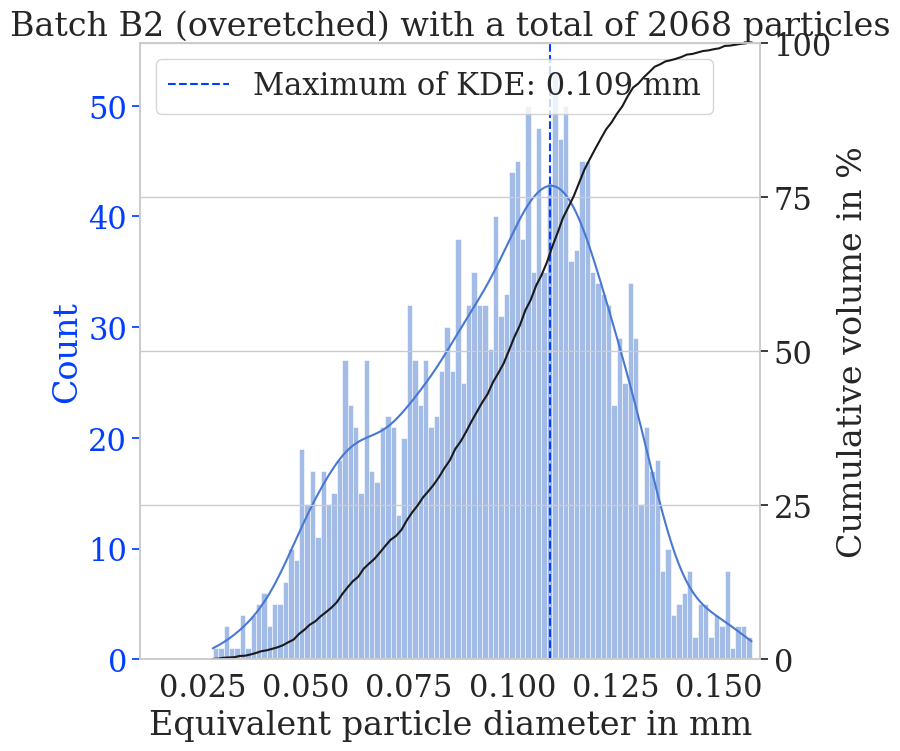

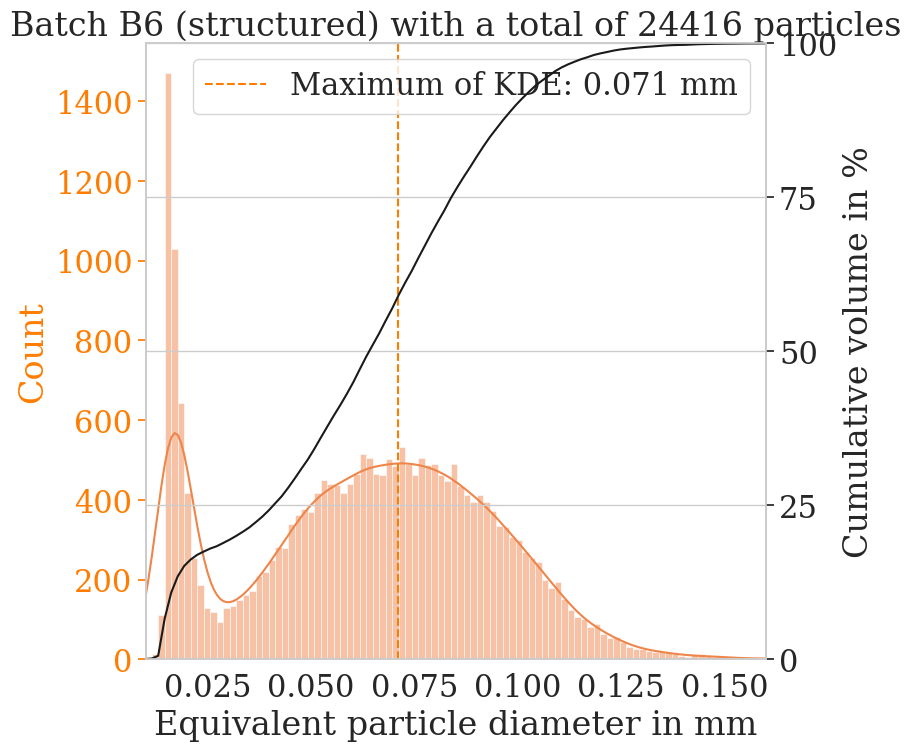

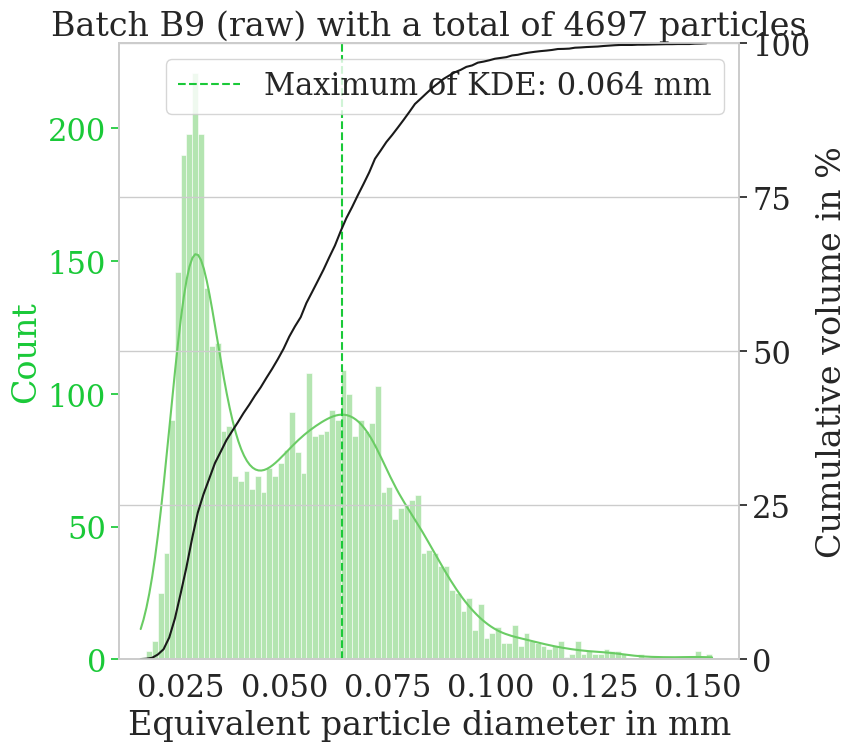

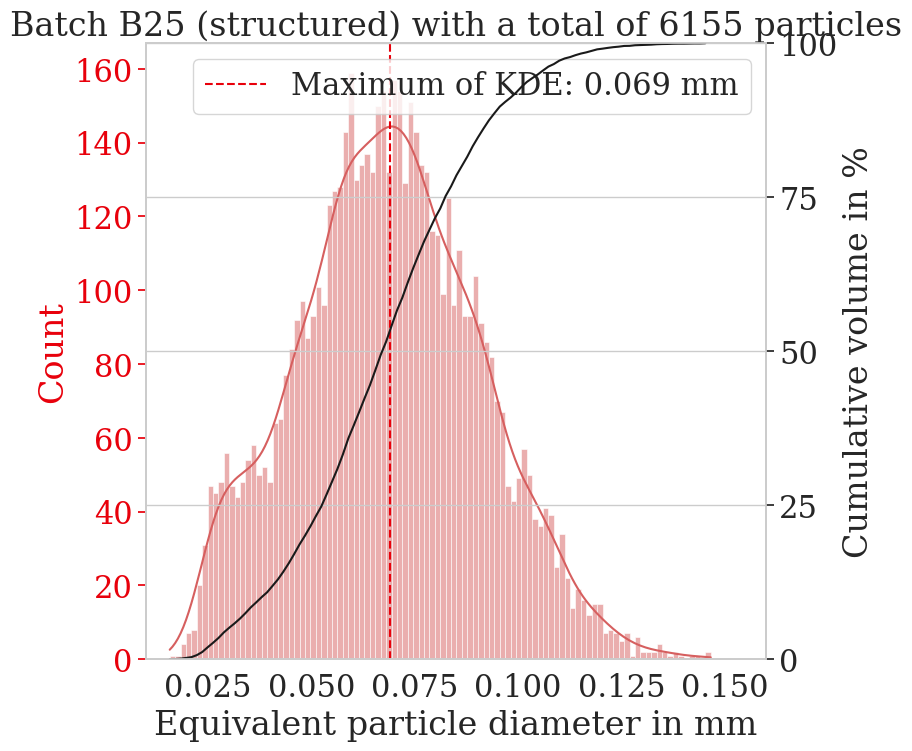

In [123]:
sns.set_context("paper")
sns.set_theme(font="serif", style="whitegrid", font_scale=2)
peaks = [0.109, 0.071, 0.064, 0.069]
cmap = sns.color_palette("muted", 4)
cmap_line = sns.color_palette("bright", 4)

for ii, batch in enumerate(batch_names):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    df = pd.DataFrame(diameter_distribution[batch], columns=["Equivalent particle diameter in mm"])
    sns.histplot(df,
                 x="Equivalent particle diameter in mm",
                 bins=100,
                 ax=ax,
                 kde=True,
                 color=cmap[ii])
    ax2 = ax.twinx()
    sns.lineplot(data=pd.DataFrame(cumulative_volume[batch]),
                    x="x",
                    y="y",
                    ax=ax2,
                    color="k")
    ax2.grid("minor")
    ax2.legend([], [], frameon=False)
    ax2.set_ylabel("Cumulative volume in %")
    ax2.set_ylim(0, 100)
    ax2.set_yticks(np.arange(0, 101, 25))
    ax.axvline(peaks[ii], color=cmap_line[ii], linestyle="--", label="Maximum of KDE: " + str(peaks[ii]) + " mm")
    ax.legend(loc="upper left" if batch == "B2 (overetched)" else "upper right")
    ax.set_title("Batch " + batch + " with a total of " + str(len(diameter_distribution[batch])) + " particles")
    ax.set_ylabel('Count')
    ax.set_xlim(0.01, 0.16)
    ax.grid(False)
    ax.yaxis.label.set_color(cmap_line[ii])
    ax.tick_params(axis='y', colors=cmap_line[ii])
    fig.savefig("../../06_Results/ParticleSizeDistribution/" + batch + ".pdf", bbox_inches="tight", pad_inches=0)
    fig.savefig("../../06_Results/ParticleSizeDistribution/" + batch + ".png", bbox_inches="tight", pad_inches=0)

# Time constant testing
Contact between Al and PMMA depending on settings.

In [7]:
bad_specimen = [
    "AD33", # density is extemely high as calculated due to lots of small particles. Actual density from image is smaller.
    "AD31", # uneven clamping pressure
]

df = specimen_overview[
    (specimen_overview["analysis"] == "y")
    & (~specimen_overview["specimen"].isin(bad_specimen))
    & ((specimen_overview["description"] == "time constant testing")
    | (specimen_overview["description"] == "standard setting batch test"))][["specimen", "settings", "Batch"]]



settings = df["settings"].apply(lambda x: [int(ii) for ii in re.findall(r'\d+', x)]).values
all_settings = []
for setting in settings:
    if setting == []: # Standard setting
        all_settings.append(get_func_gen_settings(on_time=0.01, off_time=0.02, passes=10, focus_distance=45, verbose=False))
    else:
        all_settings.append(get_func_gen_settings(on_time=setting[1] * 1e-3, off_time=setting[2] * 1e-3, passes=setting[0],
                                              focus_distance=45, verbose=False))

df = df.reset_index(drop=True)
df_settings = pd.DataFrame(all_settings)
df = df.join(df_settings[["actual_on_time", "actual_off_time", "passes", "equivalent_energy"]])
df["air_volume"] = [analytics[specimen]["mask_analytics"]["total_air_volume_mm3"] * 2 ** 3 for specimen in
                    df["specimen"]]
df["ratio"] = np.round(df["actual_off_time"] / df["actual_on_time"])
df["density"] = [1/(np.mean(analytics[specimen]["2d_cell_area"] * SCALE_FACTOR_2D)) for specimen in df["specimen"]]
df["contact"] = [100 - analytics[specimen]["mask_analytics"]["contact_air_Al_percent"] for specimen in df["specimen"]]
df = df.drop(["settings"], axis=1)
df = df[df["Batch"] == "B6"].drop("Batch", axis=1)
df[["specimen", "contact","density", "ratio", "air_volume"]]
df

,specimen,actual_on_time,actual_off_time,passes,equivalent_energy,air_volume,ratio,density,contact
3,AD63,0.010042,0.020083,10,0.641026,0.131021,2.0,67.376339,93.057777
5,AD43,0.009979,0.019959,7,0.445931,0.057550,2.0,66.814036,95.272177
6,AD42,0.009979,0.019959,5,0.318522,0.487759,2.0,52.479889,71.981411
10,AD32,0.020083,0.080333,10,1.282051,0.295336,4.0,37.223590,73.396743
11,AD29,0.005021,0.020083,10,0.320513,0.222252,4.0,40.253008,90.566323
12,AD28,0.010042,0.020083,10,0.641026,0.127393,2.0,22.727352,94.699598
13,AD21,0.010042,0.020083,10,0.641026,0.149902,2.0,102.315294,83.920099
14,AD20,0.048063,0.143207,7,2.147710,0.534732,3.0,48.253974,58.750714
15,AD19,0.043800,0.088618,7,1.957214,1.897105,2.0,42.115388,41.428174
16,AD18,0.034928,0.034928,3,0.668896,0.040539,1.0,74.686125,92.745599


In [15]:
specimen = "AD52"
path = "../../04_uCT/" + specimen + "/"
scan = Scan(path,
            downscale=False)
scan.load(logging=False)
scan.show("z")

Loading pickled Scan object from: ../../06_Results/uCT/AD52/Scan.pkl


In [17]:
scan.voxel_size_mm

0.00247693993

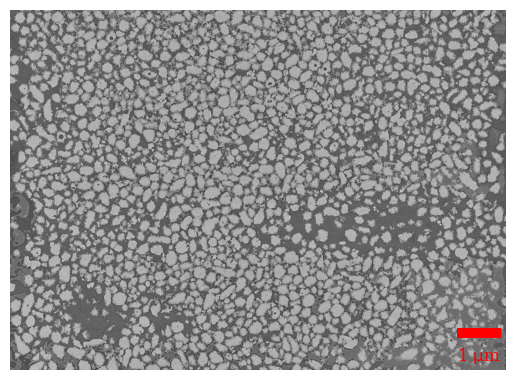

In [21]:
scan.export_image("stack", region_of_interest=[0, 0, 1], aspect_ratio=1)

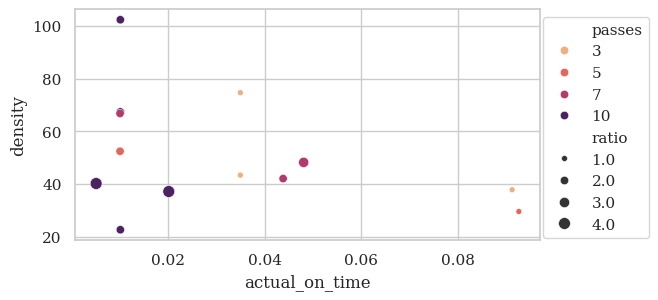

In [118]:
sns.set_context("paper")
sns.set_theme(font="serif", style="whitegrid", font_scale=1)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.scatterplot(data=df,
                x="actual_on_time",
                y="density",
                size="ratio",
                hue="passes",
                ax=ax,
                palette="flare")
ax.legend(bbox_to_anchor=(1.25, 1))
fig.savefig("../../06_Results/SettingsTest/param_overview.pdf", bbox_inches="tight", pad_inches=0)
fig.savefig("../../06_Results/SettingsTest/param_overview.png", bbox_inches="tight", pad_inches=0)

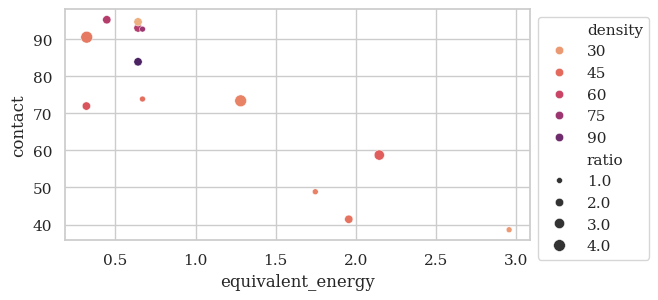

In [9]:
sns.set_context("paper")
sns.set_theme(font="serif", style="whitegrid", font_scale=1)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.scatterplot(data=df,
                x="equivalent_energy",
                y="contact",
                size="ratio",
                hue="density",
                ax=ax,
                palette="flare")
ax.legend(bbox_to_anchor=(1, 1))
fig.savefig("../../06_Results/SettingsTest/param_contact.pdf", bbox_inches="tight", pad_inches=0)
fig.savefig("../../06_Results/SettingsTest/param_contact.png", bbox_inches="tight", pad_inches=0)

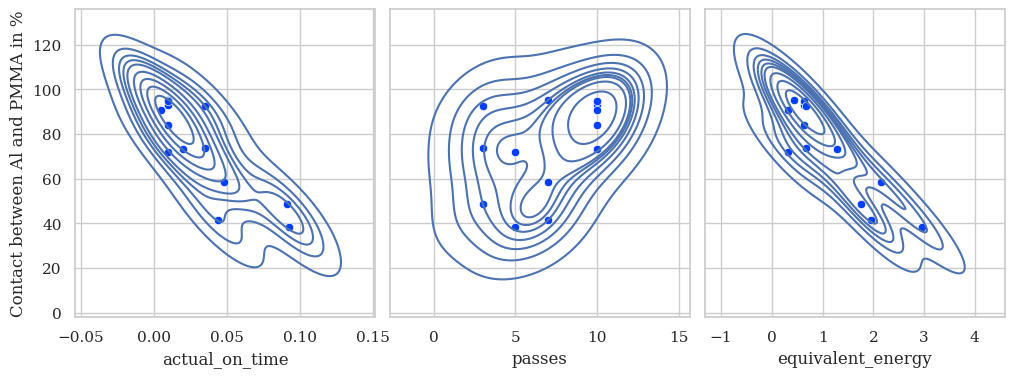

In [101]:
sns.set_context("paper")
sns.set_theme(font="serif", style="whitegrid", font_scale=1)
bright = sns.color_palette("bright", 1)
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.05)
sns.scatterplot(data=df, x="actual_on_time", y="contact",ax=axs[0], color=bright)
sns.kdeplot(data=df, x="actual_on_time", y="contact", ax=axs[0])
sns.scatterplot(data=df, x="passes", y="contact", ax=axs[1], color=bright)
sns.kdeplot(data=df, x="passes", y="contact", ax=axs[1])
sns.scatterplot(data=df, x="equivalent_energy", y="contact", ax=axs[2], color=bright)
sns.kdeplot(data=df, x="equivalent_energy", y="contact", ax=axs[2])
axs[0].set_ylabel("Contact between Al and PMMA in %")
fig.savefig("../../06_Results/SettingsTest/onEnergyPasses_contact.pdf", bbox_inches="tight", pad_inches=0)
fig.savefig("../../06_Results/SettingsTest/onEnergyPasses_contact.png", bbox_inches="tight", pad_inches=0)

Does not work well, no correlation found:

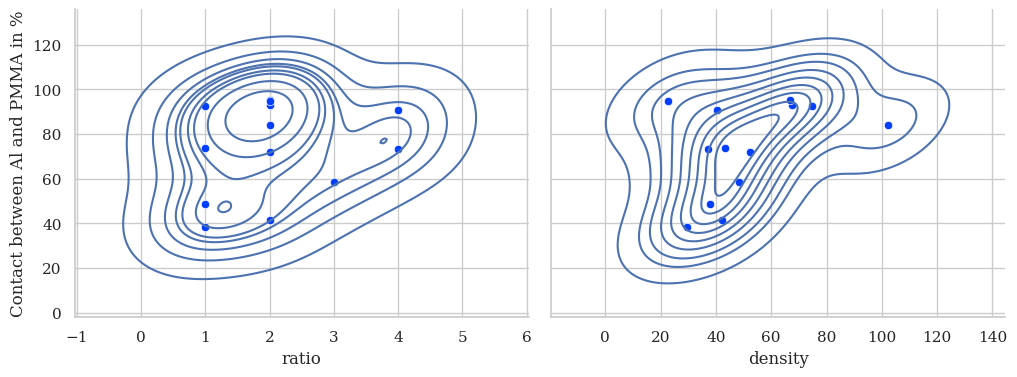

In [102]:
sns.set_context("paper")
sns.set_theme(font="serif", style="whitegrid", font_scale=1)
bright = sns.color_palette("bright", 1)
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.05)
sns.scatterplot(data=df, x="ratio", y="contact", ax=ax[0], color=bright)
sns.kdeplot(data=df, x="ratio", y="contact", ax=ax[0])
sns.scatterplot(data=df, x="density", y="contact", ax=ax[1], color=bright)
sns.kdeplot(data=df, x="density", y="contact", ax=ax[1])
ax[0].set_ylabel("Contact between Al and PMMA in %")
sns.despine(fig)
fig.savefig("../../06_Results/SettingsTest/densityRatio_contact.pdf", bbox_inches="tight", pad_inches=0)
fig.savefig("../../06_Results/SettingsTest/densityRatio_contact", bbox_inches="tight", pad_inches=0)

In [103]:
# sns.pairplot(df, hue="specimen", corner=True, diag_kind="kde")
# plt.savefig("../../06_Results/SettingsTest/Pairplot.pdf", bbox_inches="tight", pad_inches=0)

# Standard Settings, different batches

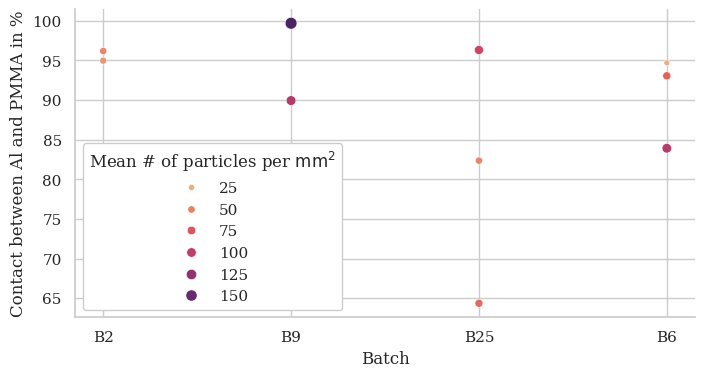

In [104]:
df = specimen_overview[
    (specimen_overview["analysis"] == "y")
    & ((specimen_overview["description"] == "standard setting batch test")
       | ((specimen_overview["description"] == "time constant testing")
          & (specimen_overview["settings"] == "standard")))
    ][["specimen", "Batch"]]
df["mean_cell_area"] = [1/(np.mean(analytics[specimen]["2d_cell_area"] * SCALE_FACTOR_2D)) for specimen in df["specimen"]]
df["contact"] = [100 - analytics[specimen]["mask_analytics"]["contact_air_Al_percent"] for specimen in df["specimen"]]


sns.set_context("paper")
sns.set_theme(font="serif", style="whitegrid", font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.scatterplot(data=df, 
                x="Batch", 
                y="contact", 
                size="mean_cell_area", 
                hue="mean_cell_area", 
                palette="flare",
                ax=ax)
ax.set_ylabel("Contact between Al and PMMA in %")
ax.set_xlabel("Batch")
ax.legend(title="Mean # of particles per $\mathrm{mm}^2$", framealpha=1)
sns.despine(ax=ax)
fig.savefig("../../06_Results/SettingsTest/StandardSetting_Batches.pdf", bbox_inches="tight", pad_inches=0)
fig.savefig("../../06_Results/SettingsTest/StandardSetting_Batches.png", bbox_inches="tight", pad_inches=0)